In [1]:
import pandas as pd
import numpy as np
import cloudpickle

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline


# ---------------------------
# 1. 데이터 불러오기
# ---------------------------
df = pd.read_csv("customer_Info copy.csv")
df = df.drop(columns=["customerID"])
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce").fillna(0)
df["Churn"] = df["Churn"].replace({"Yes": 1, "No": 0})

X = df.drop(columns=["Churn"])
y = df["Churn"]

numeric_features = ["tenure", "MonthlyCharges", "TotalCharges"]
categorical_features = [col for col in X.columns if col not in numeric_features]


# ---------------------------
# 2. 전처리 + 모델 파이프라인
# ---------------------------
def clean_numeric(X):
    X = X.copy()
    for col in ["TotalCharges", "MonthlyCharges", "tenure"]:
        X[col] = pd.to_numeric(X[col], errors="coerce").fillna(0)
    return X

numeric_cleaner = FunctionTransformer(clean_numeric)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
    ]
)

pipeline = Pipeline(steps=[
    ("cleaner", numeric_cleaner),
    ("preprocessor", preprocessor),
    ("smote", SMOTE(random_state=42)),
    ("clf", RandomForestClassifier(random_state=42, class_weight="balanced"))
])


# ---------------------------
# 3. 하이퍼파라미터 튜닝
# ---------------------------
param_grid = {
    "clf__n_estimators": [200, 500],
    "clf__max_depth": [10, 20, None],
    "clf__min_samples_split": [2, 5],
    "clf__min_samples_leaf": [1, 2],
    "clf__max_features": ["sqrt", "log2"]
}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring="recall",
    cv=skf,
    n_jobs=-1,
    verbose=2
)


# ---------------------------
# 4. 학습 & 보정
# ---------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

grid_search.fit(X_train, y_train)
print("최적 파라미터:", grid_search.best_params_)
print("최고 Recall:", grid_search.best_score_)

best_pipeline = grid_search.best_estimator_

calibrated_rfc = CalibratedClassifierCV(
    estimator=best_pipeline,
    method="sigmoid",
    cv=5
)
calibrated_rfc.fit(X_train, y_train)

# ---------------------------
# 5. 추가 세그먼트용 KMeans
# ---------------------------
y_prob = calibrated_rfc.predict_proba(X)[:, 1]
X_cluster = pd.DataFrame({
    "ChurnProbability": y_prob,
    "MonthlyCharges": X["MonthlyCharges"]
})

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
kmeans.fit(X_scaled)


# ---------------------------
# 6. 저장 (모델 + 스케일러 + 클러스터러)
# ---------------------------
bundle = {
    "model": calibrated_rfc,
    "scaler": scaler,
    "kmeans": kmeans
}

with open("pipeline_customer_churn_model.pkl", "wb") as f:
    cloudpickle.dump(bundle, f)

print("✅ 모델 + KMeans + Scaler 저장 완료")


C:\Users\honor\AppData\Local\Temp\ipykernel_9688\964693702.py:22: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["Churn"] = df["Churn"].replace({"Yes": 1, "No": 0})


Fitting 5 folds for each of 48 candidates, totalling 240 fits
최적 파라미터: {'clf__max_depth': 10, 'clf__max_features': 'log2', 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 2, 'clf__n_estimators': 200}
최고 Recall: 0.6240802675585285
✅ 모델 + KMeans + Scaler 저장 완료


C:\Users\honor\AppData\Local\Temp\ipykernel_9688\314150444.py:32: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["Churn"] = df["Churn"].replace({"Yes": 1, "No": 0})


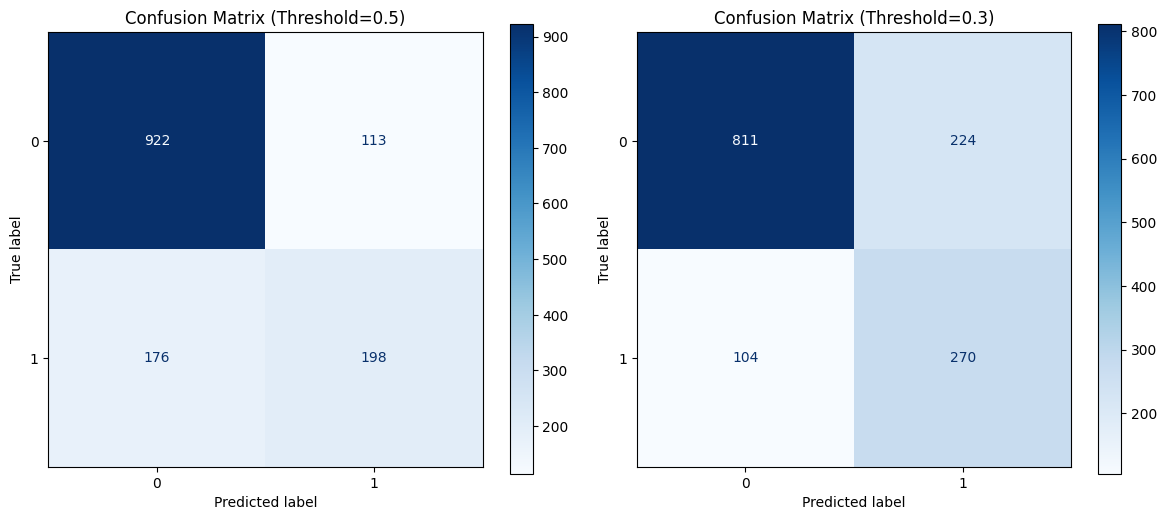

Threshold 0.5
               precision    recall  f1-score   support

           0       0.84      0.89      0.86      1035
           1       0.64      0.53      0.58       374

    accuracy                           0.79      1409
   macro avg       0.74      0.71      0.72      1409
weighted avg       0.79      0.79      0.79      1409

Threshold 0.3
               precision    recall  f1-score   support

           0       0.89      0.78      0.83      1035
           1       0.55      0.72      0.62       374

    accuracy                           0.77      1409
   macro avg       0.72      0.75      0.73      1409
weighted avg       0.80      0.77      0.78      1409



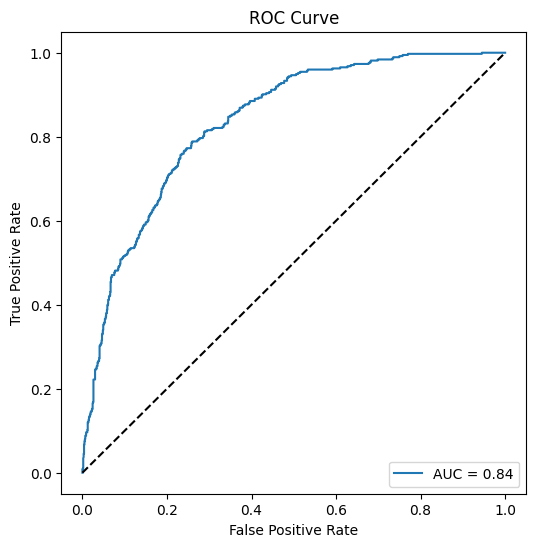

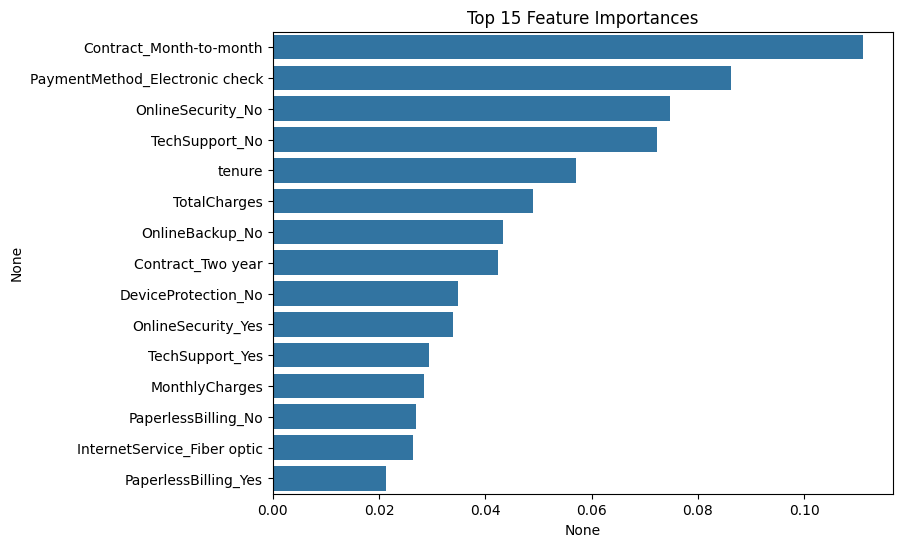

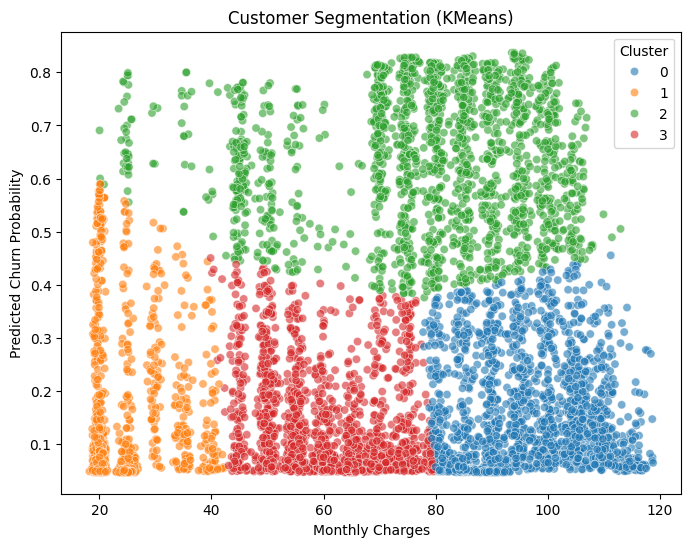

In [2]:
# ---------------------------
# 라이브러리
# ---------------------------
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import pickle
import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    roc_curve,
    auc
)

# ---------------------------
# 0. 저장 폴더 만들기
# ---------------------------
save_dir = "notebook/modeling_insight"
os.makedirs(save_dir, exist_ok=True)

# ---------------------------
# 1. 데이터 불러오기
# ---------------------------
df = pd.read_csv("customer_Info copy.csv")
df = df.drop(columns=["customerID"])
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce").fillna(0)
df["Churn"] = df["Churn"].replace({"Yes": 1, "No": 0})

X = df.drop(columns=["Churn"])
y = df["Churn"]

numeric_features = ["tenure", "MonthlyCharges", "TotalCharges"]
categorical_features = [col for col in X.columns if col not in numeric_features]

# train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ---------------------------
# 2. 저장된 모델 불러오기
# ---------------------------
with open("pipeline_customer_churn_model.pkl", "rb") as f:
    bundle = pickle.load(f)

calibrated_rfc = bundle["model"]   # CalibratedClassifierCV
scaler = bundle["scaler"]
kmeans = bundle["kmeans"]

# ---------------------------
# 3. Confusion Matrix (Threshold=0.5 vs 0.3)
# ---------------------------
y_prob_test = calibrated_rfc.predict_proba(X_test)[:, 1]

y_pred_05 = (y_prob_test >= 0.5).astype(int)
y_pred_03 = (y_prob_test >= 0.3).astype(int)

cm_05 = confusion_matrix(y_test, y_pred_05)
cm_03 = confusion_matrix(y_test, y_pred_03)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
ConfusionMatrixDisplay(cm_05).plot(ax=axes[0], cmap="Blues", values_format="d")
axes[0].set_title("Confusion Matrix (Threshold=0.5)")

ConfusionMatrixDisplay(cm_03).plot(ax=axes[1], cmap="Blues", values_format="d")
axes[1].set_title("Confusion Matrix (Threshold=0.3)")

plt.tight_layout()
plt.savefig(os.path.join(save_dir, "cm_threshold.png"), dpi=300)
plt.show()

print("Threshold 0.5\n", classification_report(y_test, y_pred_05))
print("Threshold 0.3\n", classification_report(y_test, y_pred_03))

# ---------------------------
# 4. ROC Curve
# ---------------------------
fpr, tpr, thresholds = roc_curve(y_test, y_prob_test)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.savefig(os.path.join(save_dir, "roc_curve.png"), dpi=300)
plt.show()

# ---------------------------
# 5. Feature Importance (Top 15)
# ---------------------------
rf_model = calibrated_rfc.estimator.named_steps["clf"]

importances = rf_model.feature_importances_
feature_names = (
    numeric_features
    + list(calibrated_rfc.estimator.named_steps["preprocessor"]
            .named_transformers_["cat"]
            .get_feature_names_out(categorical_features))
)

fi = pd.Series(importances, index=feature_names).sort_values(ascending=False)[:15]

plt.figure(figsize=(8,6))
sns.barplot(x=fi, y=fi.index)
plt.title("Top 15 Feature Importances")
plt.savefig(os.path.join(save_dir, "feature_importance.png"), dpi=300, bbox_inches="tight")
plt.show()

# ---------------------------
# 6. KMeans Clustering 결과
# ---------------------------
# 전체 데이터 기반 확률 예측
y_prob = calibrated_rfc.predict_proba(X)[:, 1]
X_cluster = pd.DataFrame({
    "ChurnProbability": y_prob,
    "MonthlyCharges": X["MonthlyCharges"]
})

X_scaled = scaler.transform(X_cluster)
clusters = kmeans.predict(X_scaled)

plt.figure(figsize=(8,6))
sns.scatterplot(
    x=X_cluster["MonthlyCharges"],
    y=X_cluster["ChurnProbability"],
    hue=clusters, palette="tab10", alpha=0.6
)
plt.title("Customer Segmentation (KMeans)")
plt.xlabel("Monthly Charges")
plt.ylabel("Predicted Churn Probability")
plt.legend(title="Cluster")
plt.savefig(os.path.join(save_dir, "kmeans_clusters.png"), dpi=300)
plt.show()



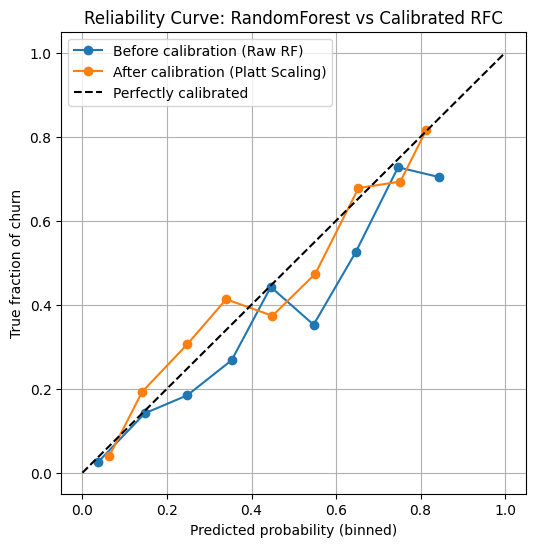

In [5]:
from sklearn.calibration import calibration_curve

# 1. 보정 전 (원래 RandomForest)
rf_model = calibrated_rfc.estimator.named_steps["clf"]   # RFC 원본 추출
preprocessor = calibrated_rfc.estimator.named_steps["preprocessor"]

# X_test 전처리 후 예측
X_test_trans = preprocessor.transform(X_test)
y_prob_rf = rf_model.predict_proba(X_test_trans)[:, 1]

# 2. 보정 후 (Calibrated RFC)
y_prob_cal = calibrated_rfc.predict_proba(X_test)[:, 1]

# calibration curve 계산
prob_true_rf, prob_pred_rf = calibration_curve(y_test, y_prob_rf, n_bins=10)
prob_true_cal, prob_pred_cal = calibration_curve(y_test, y_prob_cal, n_bins=10)

# 시각화
plt.figure(figsize=(6,6))
plt.plot(prob_pred_rf, prob_true_rf, "o-", label="Before calibration (Raw RF)")
plt.plot(prob_pred_cal, prob_true_cal, "o-", label="After calibration (Platt Scaling)")
plt.plot([0,1],[0,1],"k--", label="Perfectly calibrated")

plt.xlabel("Predicted probability (binned)")
plt.ylabel("True fraction of churn")
plt.title("Reliability Curve: RandomForest vs Calibrated RFC")
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(save_dir, "calibration_curve_comparison.png"), dpi=300)
plt.show()

